# Mask Detector

This notebook aims to determine whether or not an individual is wearing a face mask.

## Problem Definition
Given images of faces, determine whether or not the individual in the image is masked.

## Features

## Preparing the tools

In [1]:
# Data analysis and wrangling
import os
import zipfile
import pathlib
import pandas as pd
import numpy as np

# Visualization
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Modelling
import tensorflow as tf

In [2]:
!wget 'https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip'

--2021-09-14 19:15:37--  https://data-flair.s3.ap-south-1.amazonaws.com/Data-Science-Data/face-mask-dataset.zip
Resolving data-flair.s3.ap-south-1.amazonaws.com (data-flair.s3.ap-south-1.amazonaws.com)... 52.219.66.87
Connecting to data-flair.s3.ap-south-1.amazonaws.com (data-flair.s3.ap-south-1.amazonaws.com)|52.219.66.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76808601 (73M) [application/zip]
Saving to: ‘face-mask-dataset.zip’

face-mask-dataset.z 100%[===================>]  73.25M  11.8MB/s    in 7.9s    

2021-09-14 19:15:46 (9.22 MB/s) - ‘face-mask-dataset.zip’ saved [76808601/76808601]



In [3]:
# Unzip the data
zip_file = zipfile.ZipFile('face-mask-dataset.zip', 'r')
zip_file.extractall()
zip_file.close()

In [4]:
pathlist = pathlib.Path('/content/Dataset').glob('**/*.zip')
for path in pathlist:
     zip_file = zipfile.ZipFile(str(path), 'r')
     zip_file.extractall()
     zip_file.close()    

In [5]:
!mkdir data
!mv /content/test /content/data
!mv /content/train /content/data

In [6]:
# Walkthrough directories
for dirpath, dirnames, filenames in os.walk('/content/data'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in /content/data
There are 2 directories and 0 images in /content/data/train
There are 0 directories and 658 images in /content/data/train/with_mask
There are 0 directories and 657 images in /content/data/train/without_mask
There are 2 directories and 0 images in /content/data/test
There are 0 directories and 97 images in /content/data/test/with_mask
There are 0 directories and 97 images in /content/data/test/without_mask


In [7]:
# Get class names from folder names
train_dir = pathlib.Path('/content/data/train')
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['with_mask' 'without_mask']


## Visualize

In [8]:
def view_random_image(target_dir, target_class):
  """
  Returns and plots a random image from the target directory based on the target class
  """
  # Get a random image
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in and plot image
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img

Image shape: (455, 444, 3)


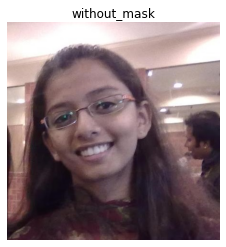

In [9]:
img = view_random_image(target_dir='/content/data/test/', target_class='without_mask')

In [10]:
img

array([[[211, 185, 186],
        [215, 189, 190],
        [216, 190, 191],
        ...,
        [234, 211, 219],
        [235, 212, 220],
        [236, 213, 221]],

       [[212, 186, 185],
        [214, 188, 187],
        [216, 190, 189],
        ...,
        [233, 210, 218],
        [234, 211, 219],
        [235, 212, 220]],

       [[214, 188, 187],
        [216, 190, 189],
        [217, 191, 190],
        ...,
        [234, 211, 219],
        [234, 211, 219],
        [234, 211, 219]],

       ...,

       [[ 50,  31,  35],
        [ 54,  35,  39],
        [ 66,  45,  50],
        ...,
        [ 77,  49,  64],
        [ 79,  51,  66],
        [ 80,  52,  67]],

       [[ 53,  32,  37],
        [ 57,  34,  40],
        [ 65,  42,  48],
        ...,
        [ 75,  47,  62],
        [ 77,  49,  64],
        [ 78,  50,  65]],

       [[ 53,  30,  36],
        [ 57,  34,  40],
        [ 63,  38,  44],
        ...,
        [ 71,  44,  59],
        [ 73,  46,  61],
        [ 74,  47,  62]]

## Preprocess and Prepare Data

In [11]:
# Set random seed
tf.random.set_seed(42)

# Preprocess data 
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup directories
train_dir = '/content/data/train'
test_dir = '/content/data/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               seed=42)

valid_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224,224),
                                             class_mode='binary',
                                             seed=42)

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


## Modelling Experiments
* Model 0: 2D Convolutional Neural Network
* Model 1: Feed-forward Neural Network
* Model 2: Same as Model 1 but more complex
* Model 3: Same as Model 0 but with augmented data

### Model 0

In [12]:
# Build
model_0 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model_0.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_0 = model_0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
42/42 [==============================] - 26s 234ms/step - loss: 0.3257 - accuracy: 0.8464 - val_loss: 0.1441 - val_accuracy: 0.9485
Epoch 2/5
42/42 [==============================] - 9s 223ms/step - loss: 0.1191 - accuracy: 0.9574 - val_loss: 0.3840 - val_accuracy: 0.8402
Epoch 3/5
42/42 [==============================] - 9s 219ms/step - loss: 0.1793 - accuracy: 0.9384 - val_loss: 0.1122 - val_accuracy: 0.9639
Epoch 4/5
42/42 [==============================] - 9s 224ms/step - loss: 0.0866 - accuracy: 0.9688 - val_loss: 0.1039 - val_accuracy: 0.9742
Epoch 5/5
42/42 [==============================] - 9s 224ms/step - loss: 0.0676 - accuracy: 0.9734 - val_loss: 0.1119 - val_accuracy: 0.9742


In [14]:
model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

### Model 1

In [16]:
# Set random seed
tf.random.set_seed(42)

# Build
model_1 = tf.keras.Sequential([
  # flatten to 1d vector for Dense layer 
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')                             
])

# Compile
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
42/42 [==============================] - 9s 211ms/step - loss: 2.4802 - accuracy: 0.4989 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/5
42/42 [==============================] - 9s 205ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
42/42 [==============================] - 8s 203ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
42/42 [==============================] - 9s 204ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/5
42/42 [==============================] - 9s 203ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000


In [17]:
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


### Model 2

In [18]:
# Set random seed
tf.random.set_seed(42)

# Build a model similar to Model 1 but with more neurons and an extra layer
model_2 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')                             
])

# Compile
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
42/42 [==============================] - 10s 204ms/step - loss: 7.4344 - accuracy: 0.5414 - val_loss: 1.3981 - val_accuracy: 0.6289
Epoch 2/5
42/42 [==============================] - 9s 208ms/step - loss: 1.7334 - accuracy: 0.6875 - val_loss: 1.5117 - val_accuracy: 0.7371
Epoch 3/5
42/42 [==============================] - 9s 207ms/step - loss: 0.5246 - accuracy: 0.8540 - val_loss: 0.4416 - val_accuracy: 0.8351
Epoch 4/5
42/42 [==============================] - 9s 207ms/step - loss: 0.2791 - accuracy: 0.8951 - val_loss: 0.6379 - val_accuracy: 0.8041
Epoch 5/5
42/42 [==============================] - 9s 209ms/step - loss: 0.4570 - accuracy: 0.8532 - val_loss: 0.3409 - val_accuracy: 0.8866


### Model 3

In [19]:
# Create augmented data
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                             rotation_range=20,
                                             shear_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir, 
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=True)

Found 1315 images belonging to 2 classes.


In [20]:
# Check augmented images
augmented_images, augmented_labels = train_data_augmented.next()

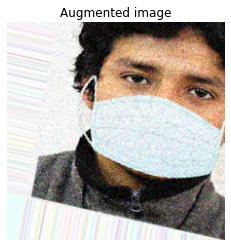

In [39]:
# Show original image and augmented image
random_number = random.randint(0, 32)
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

In [41]:
# Build
model_0 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10,
                         kernel_size=3,
                         activation='relu',
                         input_shape=(224, 224, 3)),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.Conv2D(10, 3, activation='relu'),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model_0.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit
history_0 = model_0.fit(train_data_augmented,
                        epochs=15,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/15
42/42 [==============================] - 24s 553ms/step - loss: 0.6644 - accuracy: 0.5354 - val_loss: 0.4609 - val_accuracy: 0.8351
Epoch 2/15
42/42 [==============================] - 23s 538ms/step - loss: 0.3651 - accuracy: 0.8418 - val_loss: 0.1595 - val_accuracy: 0.9485
Epoch 3/15
42/42 [==============================] - 23s 546ms/step - loss: 0.3314 - accuracy: 0.8738 - val_loss: 0.1487 - val_accuracy: 0.9639
Epoch 4/15
42/42 [==============================] - 23s 543ms/step - loss: 0.2609 - accuracy: 0.9087 - val_loss: 0.0989 - val_accuracy: 0.9742
Epoch 5/15
42/42 [==============================] - 23s 547ms/step - loss: 0.2449 - accuracy: 0.9110 - val_loss: 0.1316 - val_accuracy: 0.9536
Epoch 6/15
42/42 [==============================] - 23s 560ms/step - loss: 0.2856 - accuracy: 0.9011 - val_loss: 0.0772 - val_accuracy: 0.9845
Epoch 7/15
42/42 [==============================] - 23s 543ms/step - loss: 0.1846 - accuracy: 0.9300 - val_loss: 0.0555 - val_accuracy: 0.9845